In [1]:
import pickle
import numpy as np
import os
import torch
import torch.nn as nn
import re
import sys
from copy import deepcopy
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
import re
import pandas as pd
import seaborn as sns
from math import ceil
from sklearn.linear_model import LinearRegression

root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)
from sr_model.models.models import AnalyticSR, STDP_SR, Linear
from datasets import inputs, sf_inputs_discrete
import configs

device = 'cpu'

/Users/chingfang/Code/sr-project/datasets/inputs.py:12: UserWarning: Emily's experimental data could not be loaded.
  warnings.warn("Emily's experimental data could not be loaded.")
/Users/chingfang/Code/sr-project/datasets/sf_inputs_discrete.py:19: UserWarning: Emily's experimental data could not be loaded.
  warnings.warn("Emily's experimental data could not be loaded.")


# Collect metrics over datasets
You will have to run the corresponding python file to this jupyter notebook (will have the same title, but with 'parfor' attached).

In [32]:
gamma = 0.4
model = 'shuffle'

In [33]:
root_dir = '/Volumes/aronov-locker/Ching/03_hannah_dset_revisions/'
with open(f'{root_dir}5a_{model}_results_gamma{gamma}.p', 'rb') as f:
    results = pickle.load(f)

In [34]:
results.keys()

dict_keys(['gamma', 'arena_length', 'init_sparsities', 'sigmas', 'final_sparsities', 'fieldsizes', 'nfields', 'onefields', 'zerofields', 'fieldsizekls', 'nfieldkls'])

In [35]:
log2_e = 1.442695
nats_to_bits = lambda x: log2_e*x

In [36]:
arena_length = np.array(results['arena_length'])
init_sparsities = np.array(results['init_sparsities'])
sigmas = np.array(results['sigmas'])
final_sparsities = np.array(results['final_sparsities'])
final_sparsities = np.around(final_sparsities, decimals=2)
fieldsizes = np.array(results['fieldsizes'])
nfields = np.array(results['nfields'])
onefields = np.array(results['onefields'])
zerofields = np.array(results['zerofields'])
fieldsizekls = nats_to_bits(np.array(results['fieldsizekls']))
nfieldkls = nats_to_bits(np.array(results['nfieldkls']))

# Make contour/gradient plots

In [37]:
df = pd.DataFrame({
    'Seed Sparsity': init_sparsities,
    'Spatial Corr.': sigmas,
    'Sparsity': final_sparsities,
    'Field Size': fieldsizes,
    'Fields per Neuron': nfields,
    'Single Field Neurons': onefields,
    'Zero Field Neurons': zerofields,
    'Field Sizes KL': fieldsizekls,
    'N Fields KL': nfieldkls,
    'Total KL': np.clip(fieldsizekls + nfieldkls, 0, 10)
    })
df = df[df['Sparsity'] <= 0.2]

In [38]:
def get_edge_nans(im):
    """ im is processed row-by-row (e.g., sigma by sparsity) """
    
    mask = np.zeros(im.shape).astype(bool)
    nrows, ncols = im.shape
    for i in range(nrows):
        j = 0
        while np.isnan(im[i,j]) and (j < ncols):
            mask[i,j] = True
            j += 1
    return mask

In [39]:
def make_gradients(
    x_key, y_key, z_key, df,
    cmap="Reds",
    title=None, xlabel=None, ylabel=None,
    figname=None, figsize=[6.4, 4.8],
    interpolate=False, smooth=False, contours=None,
    leave_edge_nans=True, vmin=None, vmax=None,
    cbar_ticks=None, cbar_tick_labels=None
    ):
    
    # Load in data
    xs = df[x_key].to_numpy()
    ys = df[y_key].to_numpy()
    zs = df[z_key].to_numpy()
    
    # Collect data into a meshgrid
    x_list = np.sort(np.unique(xs))
    y_list = np.sort(np.unique(ys))
    dxs = np.around(x_list[1:] - x_list[:-1], decimals=2)
    dys = np.around(y_list[1:] - y_list[:-1], decimals=2)
    if np.unique(dxs).size > 1 or np.unique(dys).size > 1:
        if smooth:
            print("Warning: Smoothing with inconsistent dx/dy")
    x_list = np.concatenate((x_list, [x_list[-1]+dxs[-1]]))
    y_list = np.concatenate((y_list, [y_list[-1]+dys[-1]]))
    x, y = np.meshgrid(x_list, y_list)
    z = np.zeros(x.shape)
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            idx = np.logical_and(
                xs==x[i,j], ys==y[i,j]
                )
            z[i,j] = np.nanmean(zs[idx])
    cmap = plt.get_cmap(cmap)
    cmap.set_bad('yellow')

    # Plot raw grid values
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.pcolormesh(
        x, y, z, cmap=cmap
        )
    fig.colorbar(im, ax=ax)
    plt.show()
    
    # Remove padding used for pcolormesh plot
    x = x[:-1,:-1]
    y = y[:-1,:-1]
    z = z[:-1,:-1]
    
    # Mark NaNs
    nan_mask = np.isnan(z)
    edge_nan_mask = get_edge_nans(z)
    
    # Interpolate to fill in NaN cells
    if interpolate:
        if np.sum(nan_mask) > 0:
            nonnan_mask = np.logical_not(nan_mask)
            nan_indices = np.argwhere(nan_mask)
            data_X = np.vstack(
                [x[nonnan_mask].flatten(),
                 y[nonnan_mask].flatten()]).T
            data_y = z[nonnan_mask].flatten()
            reg = LinearRegression().fit(data_X, data_y)
            interp_vals = reg.predict(
                np.vstack(
                [x[nan_mask].flatten(),
                 y[nan_mask].flatten()]).T
                )
            z[nan_mask] = interp_vals

    
    # Smooth over cells to denoise
    if smooth:
        from astropy.convolution import Gaussian2DKernel
        from astropy.convolution import convolve
        kernel = Gaussian2DKernel(
            x_stddev=1., y_stddev=1.,
            #x_size=3, y_size=3
            )
        z = convolve(z, kernel, preserve_nan=True)
        
    # Generate contour plots
    fig, ax = plt.subplots(figsize=figsize)
    z = np.clip(z, 0, np.inf)
    if vmin is not None and vmax is not None:
        levels = MaxNLocator(nbins=20).tick_values(np.nanmin(vmin), np.nanmax(vmax))
    else:
        levels = MaxNLocator(nbins=20).tick_values(np.nanmin(z), np.nanmax(z))
    cf = ax.contourf(x, y, z,
                     levels=levels, cmap=cmap,
                     vmin=vmin, vmax=vmax, 
                     )
    if leave_edge_nans: # White out parts that were extrapolated
        nans = np.argwhere(edge_nan_mask)
        nan1 = nans[0]; nan2 = nans[-1]
        nan1x = x[nan1[0],nan1[1]]
        nan1y = y[nan1[0],nan1[1]]
        nan2x = x[nan2[0],nan2[1]]
        nan2y = y[nan2[0],nan2[1]]
        max_y = y.max()
        plt.fill(
            [nan1x, nan2x, nan1x],
            [nan1y, nan2y, max_y],
            color='gray'
            )
    if contours is not None:
        cntrs = plt.contour(
            x, y, z, contours,
            colors='gray', linewidths=0.5
            )
        plt.clabel(cntrs, inline=True)
    cbar = fig.colorbar(cf, ax=ax, ticks=cbar_ticks)
    if cbar_ticks is not None:
        cbar.ax.set_yticklabels(cbar_tick_labels)
    ax.set_title('contourf with levels')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim(xs.min(), 0.20)
    plt.tight_layout()
    plt.savefig(f'{figname}.png', dpi=300, transparent=True)
    plt.show()
    
    return x, y, z

In [40]:
def get_nan_mask(im, leave_edge_nans=False):
    """ im is processed row-by-row (e.g., sigma by sparsity) """
    
    if not leave_edge_nans:
        return np.isnan(im)
    else:
        mask = np.isnan(im)
        nrows, ncols = im.shape
        for i in range(nrows):
            j = 0
            while np.isnan(im[i,j]) and (j < ncols):
                mask[i,j] = False
                j += 1
        return mask

/var/folders/jf/2_wn4hjd11q9klftv_v_hld80000gn/T/ipykernel_12195/2643133150.py:33: RuntimeWarning: Mean of empty slice
  z[i,j] = np.nanmean(zs[idx])
/var/folders/jf/2_wn4hjd11q9klftv_v_hld80000gn/T/ipykernel_12195/2643133150.py:35: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("Purples").copy()
  cmap.set_bad('yellow')
/var/folders/jf/2_wn4hjd11q9klftv_v_hld80000gn/T/ipykernel_12195/2643133150.py:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(


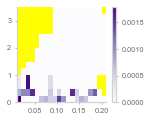

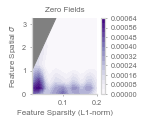

In [41]:
_, _, _ = make_gradients(
    'Sparsity', 'Spatial Corr.', 'Zero Field Neurons', df,
    cmap='Purples',
    title='Zero Fields',
    xlabel='Feature Sparsity (L1-norm)',
    ylabel='Feature Spatial $\sigma$',
    figname='../figures/S_identity_6d',
    interpolate=True, smooth=True,
    #cbar_ticks=[0, 0.05, 0.1],
    cbar_tick_labels=['0.0', '', '0.1'],
    figsize=[2., 1.75]
    )

/var/folders/jf/2_wn4hjd11q9klftv_v_hld80000gn/T/ipykernel_12195/2643133150.py:33: RuntimeWarning: Mean of empty slice
  z[i,j] = np.nanmean(zs[idx])
/var/folders/jf/2_wn4hjd11q9klftv_v_hld80000gn/T/ipykernel_12195/2643133150.py:35: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("Reds").copy()
  cmap.set_bad('yellow')
/var/folders/jf/2_wn4hjd11q9klftv_v_hld80000gn/T/ipykernel_12195/2643133150.py:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(


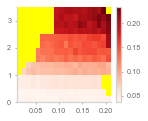

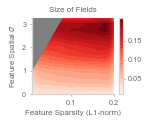

In [42]:
_,_,_ = make_gradients(
    'Sparsity', 'Spatial Corr.', 'Field Size', df,
    cmap='Reds',
    title='Size of Fields',
    xlabel='Feature Sparsity (L1-norm)',
    ylabel='Feature Spatial $\sigma$',
    figname='../figures/S_identity_6e',
    interpolate=True, smooth=True,
    cbar_ticks=[0.05, 0.1, 0.15,],
    cbar_tick_labels=['0.05', '0.10', '0.15'],
    figsize=[2.1, 1.75]
    )

/var/folders/jf/2_wn4hjd11q9klftv_v_hld80000gn/T/ipykernel_12195/2643133150.py:33: RuntimeWarning: Mean of empty slice
  z[i,j] = np.nanmean(zs[idx])
/var/folders/jf/2_wn4hjd11q9klftv_v_hld80000gn/T/ipykernel_12195/2643133150.py:35: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("Blues").copy()
  cmap.set_bad('yellow')
/var/folders/jf/2_wn4hjd11q9klftv_v_hld80000gn/T/ipykernel_12195/2643133150.py:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(


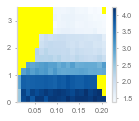

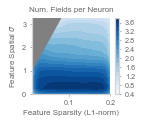

In [43]:
_, _, _ = make_gradients(
    'Sparsity', 'Spatial Corr.', 'Fields per Neuron', df,
    cmap='Blues',
    title='Num. Fields per Neuron',
    xlabel='Feature Sparsity (L1-norm)',
    ylabel='Feature Spatial $\sigma$',
    figname='../figures/S_identity_6f',
    interpolate=True, smooth=True,
    #cbar_ticks=[0, 1, 2, 3],
    cbar_tick_labels=[0, 1, 2, 3],
    figsize=[2,1.75]
    )

/var/folders/jf/2_wn4hjd11q9klftv_v_hld80000gn/T/ipykernel_12195/2643133150.py:33: RuntimeWarning: Mean of empty slice
  z[i,j] = np.nanmean(zs[idx])
/var/folders/jf/2_wn4hjd11q9klftv_v_hld80000gn/T/ipykernel_12195/2643133150.py:35: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("bone_r").copy()
  cmap.set_bad('yellow')
/var/folders/jf/2_wn4hjd11q9klftv_v_hld80000gn/T/ipykernel_12195/2643133150.py:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(


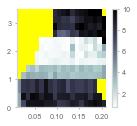

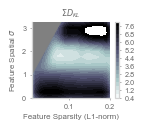

In [44]:
_,_, _z = make_gradients(
    'Sparsity', 'Spatial Corr.', 'Total KL', df,
    cmap='bone_r',
    title='$\Sigma D_{KL}$',
    xlabel='Feature Sparsity (L1-norm)',
    ylabel='Feature Spatial $\sigma$',
    figname='../figures/S_shuffle_6g',
    interpolate=True, smooth=True,
    #cbar_ticks=[0, 2, 4, 6, 8],
    #cbar_tick_labels=[0, 2, 4, 6, 8],
    figsize=[2,1.81],
    vmin=0.4, vmax=7.7
    )